In [1]:
import numpy as np
import matplotlib.pyplot as plt
from activation_functions import sigmoid, sigmoid_backward, relu, relu_backward, tanh, tanh_backward

**Double Moon Functions**

In [2]:
def double_moon_generator(w, r, d, n_samples=1000):
    
    """" Function for generating positions x and y for both moons of the problem.
         This function also returns the expected classification to be done by the neural network 
         ('1' for upper moon and '0' for lower moon). """

    # Parametrizing upper moon
    a = r + w*np.random.rand(1, n_samples)
    theta = np.pi*np.random.rand(1, n_samples)
    x1 = a*np.cos(theta)
    y1 = a*np.sin(theta)

    # Parametrizing lower moon
    a = r + w*np.random.rand(1, n_samples)
    theta = - np.pi*np.random.rand(1, n_samples)
    x2 = a*np.cos(theta) + r + w/2
    y2 = a*np.sin(theta) - d

    x = np.concatenate((x1, x2), axis=1) # Concatenating x positions for both moons
    y = np.concatenate((y1, y2), axis=1) # Concatenating y positions for both moons
    X = np.concatenate((x, y)) # Array containing x and y positions for both moons
    Y = np.concatenate((np.ones((1, x1.shape[1])), np.zeros((1, x2.shape[1]))), axis=1)
    # Expected outputs for neural network ('1' for upper moon and '0' for lower moon)
    
    aux_plot = {'x1':x1, 'y1':y1, 'x2':x2, 'y2':y2} # Auxiliary dictionary
    
    return X, Y, aux_plot

In [3]:
def plot_decision_boundary(model, X, y):
    
    """" Function for plotting the decision boundary determined by the neural network for the solution of the problem. """

    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y.ravel(), cmap=plt.cm.Spectral)

**Neural Network Functions**

In [4]:
def initialize_parameters_deep(layer_dims):

    """" Function for initializing the parameters of the network.
         Synaptic weights are initialized as of a normal distribution.
         Bias are initialized as zeros. """
    
    #layer_dims is an array containing the dimension of all layers from the network
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers from the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1)) 
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [5]:
def linear_forward(A, W, b):
  
    """" Function for propagating data through a layer of the network (before activation functions). """
    
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [6]:
def linear_activation_forward(A_prev, W, b, activation):

    """" Function for propagating data through a layer of the network (considering activation functions). 
         Cache stored due to backpropagation algorithm. """
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "tanh":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)
        
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [7]:
def forward_model(X, parameters, activation):

    """" Function for propagating data through all layers of the network (considering activation functions). 
         Caches stored due to backpropagation algorithm. """
        
    caches = []
    A = X
    L = len(parameters) // 2 # number of layers from the network
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation=activation)
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation='sigmoid')
    caches.append(cache)

    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [8]:
def compute_cost(AL, Y):

    """" Function for computing the cost/error of the output from the network.
         In this case, the cost function chosen is the cross-entropy. """
        
    m = Y.shape[1]

    cost = (-1./ m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply((1-Y), np.log( 1-AL)))
    
    cost = np.squeeze(cost)      
    assert(cost.shape == ())
    
    return cost

In [9]:
def linear_backward(dZ, cache):

    """" Function for backpropagating gradients through a layer of the network (not considering activation functions). """
    
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1. / m) * np.dot(dZ, cache[0].T) 
    db = (1. / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(cache[1].T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [10]:
def linear_activation_backward(dA, cache, activation):
    
    """" Function for backpropagating gradients through a layer of the network (considering activation functions). """
        
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "tanh":
        dZ = tanh_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)        
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [11]:
def backward_model(AL, Y, caches, activation):
    
    """" Function for backpropagating gradients through all layers of the network (considering activation functions). """
        
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation=activation)
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [12]:
def update_parameters(parameters, grads, learning_rate):

    """" Function for updating the network parameters based on the gradients achieved. """
        
    L = len(parameters)//2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [13]:
def predict(parameters, X, activation):

    """" Function for predicting the output of the network given its parameters and activation function. """
    
    AL, cache = forward_model(X, parameters, activation)
    predictions = np.round(AL)

    return predictions

**Neural Network Modeling**

In [14]:
def deep_nn_model(X, Y, layers_dims, learning_rate, num_iterations, activation, print_cost):
    
    """" Function for training a network given its architecture (layer_dims), learning_rate and activation function.
         The number of training epochs is represented by num_iterations.
         'print_cost = True' to print the cost throughout the training. """
    
    cost_vec = np.zeros(shape=(1, num_iterations))
    n_samples = X.shape[1]
    parameters = initialize_parameters_deep(layer_dims)
    
    for i in range(0, num_iterations):
        
        k = np.random.permutation(n_samples)
        X = X[:, k]
        Y = Y[:, k]
        
        AL, caches = forward_model(X, parameters, activation)
        
        cost = compute_cost(AL, Y)
        cost_vec[0][i] = cost
        
        grads = backward_model(AL, Y, caches, activation)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i%100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters, cost_vec

**Training Some Neural Networks**

10000 epochs of training (one hidden layer of 10 neurons, activation = ReLU and learning_rate = 0.15)

In [15]:
X, Y, aux_plot = double_moon_generator(w=5, r=10, d=-5)
x1 = aux_plot['x1']
y1 = aux_plot['y1']
x2 = aux_plot['x2']
y2 = aux_plot['y2']
layer_dims = np.array([X.shape[0], 10, Y.shape[0]]) # one hidden layer of 10 neurons

# Training the network
parameters, cost_vec = deep_nn_model(X, Y, layer_dims, learning_rate=0.15, num_iterations=10000, activation='relu', print_cost=False)

In [16]:
# Evaluating accuracy
predictions = predict(parameters, X, activation='relu')
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

Accuracy: 100%


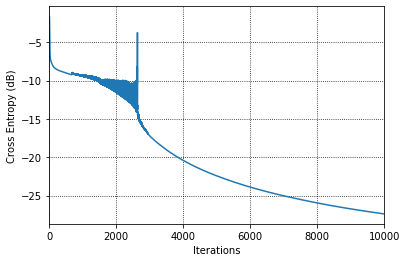

In [17]:
# Plotting costs
plt.plot(10*np.log10(cost_vec[0][:]))
plt.xlabel('Iterations')
plt.xlim(0,10000)
plt.ylabel('Cross Entropy (dB)')
plt.grid(color='black', linestyle='dotted')
plt.show()

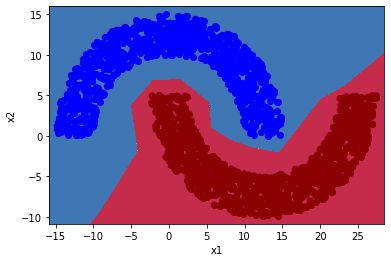

In [18]:
# Plotting decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T, activation='relu'), X, Y)
plt.scatter(x1, y1, c='b')
plt.scatter(x2, y2, c='#8B0000')

3000 epochs of training (two hidden layers of 20 neurons each, activation = Hyperbolic Tangent and learning_rate = 0.15)

In [19]:
X, Y, aux_plot = double_moon_generator(w=5, r=10, d=-5)
x1 = aux_plot['x1']
y1 = aux_plot['y1']
x2 = aux_plot['x2']
y2 = aux_plot['y2']
layer_dims = np.array([X.shape[0], 20, 20, Y.shape[0]]) # two hidden layers of 20 neurons each

# Training the network
parameters, cost_vec = deep_nn_model(X, Y, layer_dims, learning_rate=0.15, num_iterations=3000, activation='tanh', print_cost=False)

In [20]:
# Evaluating accuracy
predictions = predict(parameters, X, activation='tanh')
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

Accuracy: 100%


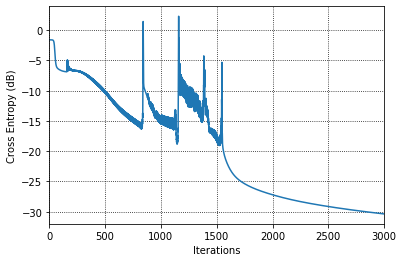

In [21]:
# Plotting costs
plt.plot(10*np.log10(cost_vec[0][:]))
plt.xlabel('Iterations')
plt.xlim(0,3000)
plt.ylabel('Cross Entropy (dB)')
plt.grid(color='black', linestyle='dotted')
plt.show()

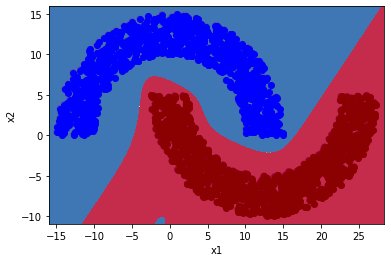

In [22]:
# Plotting decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T, activation='tanh'), X, Y)
plt.scatter(x1, y1, c='b')
plt.scatter(x2, y2, c='#8B0000')